[该篇文章参考了这个](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

# 导入函数库

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, transforms, datasets
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.tensorboard import SummaryWriter
import copy

# 设置transform, 用于数据转换

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # 训练集使用的random_crop
        transforms.RandomHorizontalFlip(),  # 随机左右翻转
        transforms.ToTensor(),
        # output[channel] = (input[channel] - mean[channel]) / std[channel]
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 前者是mean, 后者是std
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),   # 先resize到256
        transforms.CenterCrop(224),   # 验证集使用的center_crop
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# 训练的时候记得把数据和网络都传到GPU上

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  # 通过cuda:0指定第一块GPU

# 加载训练集和测试集，并进行batch_size, shuffle等设置

In [4]:
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                 for x in ['train', 'val']}  # 此处的数据集是从文件夹读取的
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val']}   # 这里的话，训练集和验证集都设置为shuffle=True，一般来说验证集shuffle=False

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# 类别名称

In [5]:
class_names = image_datasets['train'].classes

# 图片可视化函数

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))  # pytorch接受的是CHW，所以要先转化成HWC再进行imshow
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean   # 还原像素值
    inp = np.clip(inp, 0, 1)  # 对超过1和小于0的结果进行截断
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 停留一段时间再显示

## 可视化一个batch的训练集图片

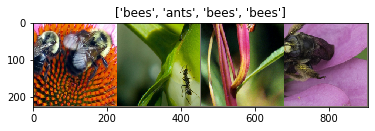

In [7]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 封装训练模型函数，其中要注意的点是网络中存在batchnorm，所以在训练的时候model要处于training, 推理的时候model要处于eval

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()  # 开始时间
    
    # 用于保存最好的模型权重和对应的最高的准确率
    best_acc_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 因为模型中存在dropout等，所以训练的时候模型要处于training状态
            else:
                model.eval()  # 推理的时候模型要处于eval状态
            
            running_loss = 0.0  # 记录损失值
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                # 数据要传到GPU设备上
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()  # 梯度清零
                
                with torch.set_grad_enabled(phase == 'train'):  # 训练的时候计算梯度，推理的时候不计算梯度
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)  # 计算损失值
                    
                    if phase == 'train':  # 训练的时候，要反向传播以及梯度更新
                        loss.backward()
                        optimizer.step()
                #因为loss.item()返回的是单个样本的损失值，所以要乘上batch_size，所以每个step,running_loss加上的是mini-batch的损失值
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train': # 训练的时候要使用learning rate scheduler
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase] # 最终这里计算的还是单个样本的损失值，不过是均值
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc: # 判断当前epoch的acc是否比之前的最高准确率还高
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
        
    time_elapsed = time.time() - since  # 模型训练所用时长
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)  #加载最优模型并返回
    return model

# 利用训练好的模型进行推理预测，并可视化预测结果

In [9]:
def visualize_model(model, num_images):
    was_training = model.training  #记录模型的状态，一般是training，这里返回结果是True
    model.eval()  # 推理的时候模型状态设置为eval,因为存在dropout等
    images_so_far = 0
    
    fig = plt.figure()
    
    with torch.no_grad(): # 推理的时候不计算梯度
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            # 数据要传到GPU上
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])  # imshow的时候要把数据传到CPU上
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)# 最终返回的模型要重新设置为training状态

# 定义网络结构，此处采用的是训练整个模型，可以看做把预训练过的模型参数拿来当做参数初始化

## 因为预训练的模型是在ImageNet上的，最后一层有1000个神经元，所以要替换最后一层

In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

## 把网络传到GPU上

In [11]:
model_ft.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 模拟输入，要和预训练模型的输入shape对应上，此处是为了保存模型用于可视化

In [12]:
inputs = torch.ones([1, 3, 224, 224], dtype=torch.float32)

## 声明一个writer实例，用于写入events

In [13]:
writer = SummaryWriter('runs/transfer_learning')

## 把模型写入硬盘

In [14]:
writer.add_graph(model_ft, inputs.to(device))
writer.close()

## 定义损失函数和优化器和LearningRateScheduler设置

In [15]:
criterion = nn.CrossEntropyLoss()  # 一般用于分类
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)  #使用指数衰减学习率

## 训练模型，设置epoch=25

In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6562 Acc: 0.6762
val Loss: 0.2181 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.5808 Acc: 0.7500
val Loss: 0.2666 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.3647 Acc: 0.8443
val Loss: 0.2398 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.5569 Acc: 0.7910
val Loss: 0.3422 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.4857 Acc: 0.8197
val Loss: 0.2441 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.6096 Acc: 0.7828
val Loss: 0.2296 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4127 Acc: 0.8320
val Loss: 0.2772 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.3994 Acc: 0.8607
val Loss: 0.2465 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.4009 Acc: 0.8443
val Loss: 0.2582 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3125 Acc: 0.8770
val Loss: 0.2383 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3197 Acc: 0.8648
val Loss: 0.2427 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2785 Acc: 0.8770
val Loss: 0.2724 Acc: 0.8954

Ep

## 利用训练好的模型预测一个batch的图片

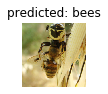

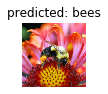

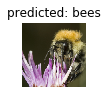

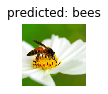

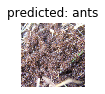

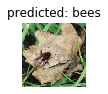

In [17]:
visualize_model(model_ft, 6)

# 定义网络结构，不同的是，这里把特征提取层freeze了，也就是在训练的时候参数是不更新的

## 实例化一个resnet18网络，并冻结网络参数

In [18]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

## 替换网络的最后一层

In [19]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

## 把模型传送到GPU设备上

In [20]:
model_conv = model_conv.to(device)

## 定义损失函数和优化器和LearningRateScheduler

In [21]:
criterion = nn.CrossEntropyLoss() # 一般用于分类
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1) # 使用指数衰减学习率

## 训练模型，设置epoch=25

In [22]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6727 Acc: 0.6393
val Loss: 0.3285 Acc: 0.8431

Epoch 1/24
----------
train Loss: 0.6301 Acc: 0.7336
val Loss: 0.1806 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.4345 Acc: 0.8115
val Loss: 0.3165 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.4185 Acc: 0.8074
val Loss: 0.2008 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.3852 Acc: 0.8361
val Loss: 0.5332 Acc: 0.8039

Epoch 5/24
----------
train Loss: 0.5406 Acc: 0.7705
val Loss: 0.3058 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.5622 Acc: 0.7582
val Loss: 0.2426 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3833 Acc: 0.8279
val Loss: 0.1838 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.4192 Acc: 0.7951
val Loss: 0.1892 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3422 Acc: 0.8566
val Loss: 0.1790 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3620 Acc: 0.8320
val Loss: 0.1865 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3575 Acc: 0.8525
val Loss: 0.1988 Acc: 0.9346

Ep

## 可视化预测结果

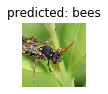

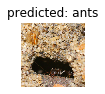

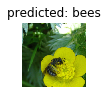

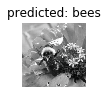

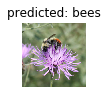

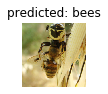

In [23]:
visualize_model(model_conv, 6)

# 总结是否freeze网络的区别

对比可以发现，freeze特征提取层之后，模型训练的参数量少了，训练的速度更快了，前者为34s，后者为23秒，GPU为2070 Super